# 문서 군집화 실습

- 기존에 배웠던 텍스트 분류는 사전에 label(정답)이 존재하는 지도학습
- 지금 하는 ``문서군집화``는 사전에 label(정답, 즉 문서의 카테고리)이 존재하지 않는 상태에서 군집화하는 ``비지도 학습``

In [27]:
import pandas as pd
import os
os.chdir('/Users/younghun/Desktop/gitrepo/data/topics')

In [28]:
# glob는 파일들의 리스트를 뽑아낼 때 자주 사용
# 경로명도 입맛대로 뽑아낼 수 있음
# glob(r'C:\U*) => C:\U로 시작하는 경로명 
import glob
path = r'/Users/younghun/Desktop/gitrepo/data/topics'
# path경로에서 .data로이루어진 모든 파일들을 리스트에 담아라!
all_files = glob.glob(os.path.join(path, '*.data'))

In [29]:
filename_lst = []
opinion_text = []

#개별 파일들의 파일명들 리스트에 따로 담고
#개별 파일들의 텍스트를 리스트에 따로 담은 후 데이터프레임으로 만들기
for file in all_files:
    # .data file은 read_tabel로 읽기 delimeter인자 안주면 내용 하나의 데이터로 간주
    df = pd.read_table(file, index_col=None, header=0,
                      encoding='latin1')
    # 절대경로가 포함된 파일명에서 파일명만 추출
    filename = file.split('/')[-1]
    filename = filename.split('.')[0]
    # 파일명 리스트 담기
    filename_lst.append(filename)
    # df을 모두 문자열로 만들어주기 위해 to_string() 사용!
    opinion_text.append(df.to_string())

# 최종 데이터프레임 완성
document_df = pd.DataFrame({'filename':filename_lst,
                           'opinion_text':opinion_text})
document_df.head()

,filename,opinion_text
0,battery-life_ipod_nano_8gb,...
1,gas_mileage_toyota_camry_2007,...
2,room_holiday_inn_london,...
3,location_holiday_inn_london,...
4,staff_bestwestern_hotel_sfo,...


In [36]:
# 텍스트 단어들의 어근 원형을 추출하기 위해 함수 생성
from nltk.stem import WordNetLemmatizer
import nltk
import string
# string.puncutaion에 문자열의 모든 구두점이 들어있음
# 이를 활용해서 Tokenize시킬 때 구두점들을 제외하기 위한 것
# ord('문자열') => 문자열의 ASCII코드를 반환해줌!
# dict(key, value)형태로 모든 구두점의 각 ASCII코드를 key값으로 넣어주자!
remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmar = WordNetLemmatizer()

# 토큰화한 각 단어들의 원형들을 리스트로 담아서 반환
def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]
# 텍스트를 Input으로 넣어서 토큰화시키고 토큰화된 단어들의 원형들을 리스트로 담아 반환
def LemNormalize(text):
    # .translate인자에 구두점 dict넣어주어서 구두점 삭제해준 상태로 토큰화시키기!
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))


In [37]:
# .translate 예시
test = 'I am looking for a cat.'
nltk.word_tokenize(test.lower().translate(remove_punct_dict))

['i', 'am', 'looking', 'for', 'a', 'cat']

In [38]:
# Tf-idf 벡터화시키면서 cusotmized해준 토큰화+어근추출 방식 tokenizer인자에 넣어주기
from sklearn.feature_extraction.text import TfidfVectorizer

# 벡터화시킬 Tf-idf 도구 옵션 추가해서 구축
# 1,2gram적용, 빈도수 0.05이하, 0.85이상의 빈도수 단어들 제거
tfidf_vect = TfidfVectorizer(tokenizer=LemNormalize,
                            stop_words='english', ngram_range=(1,2),
                            min_df=0.05, max_df=0.85)
# fit_transform으로 위에서 구축한 도구로 텍스트 벡터화
ftr_vect = tfidf_vect.fit_transform(document_df['opinion_text'])
print(ftr_vect.shape)

/Users/younghun/opt/anaconda3/envs/venvforpython/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(51, 4611)


In [39]:
# K-means로 3개 군집으로 문서 군집화시키기
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, max_iter=10000, random_state=42)
# 비지도 학습이니 feature로만 학습시키고 예측
cluster_label = kmeans.fit_predict(ftr_vect)

# 군집화한 레이블값들을 document_df 에 추가하기
document_df['cluster_label'] = cluster_label
document_df.sort_values(by=['cluster_label'])

,filename,opinion_text,cluster_label
50,parking_bestwestern_hotel_sfo,...,0
27,service_holiday_inn_london,...,0
28,price_holiday_inn_london,...,0
30,rooms_swissotel_chicago,...,0
20,staff_swissotel_chicago,...,0
31,bathroom_bestwestern_hotel_sfo,...,0
32,food_swissotel_chicago,...,0
17,food_holiday_inn_london,...,0
16,service_bestwestern_hotel_sfo,...,0
13,service_swissotel_hotel_chicago,...,0


## 군집별 핵심 단어 추출

- Kmeans가 반환해주는 속성인 cluster_centers_를 활용하기

- 문서 군집화 문제에서 cluster_centers_ 의미
    * 0~1 사이의 값으로 벡터화 시킨 feature(단어)들의 값이 개별적으로 도출
    * 이는 개별 단어들이 클러스터 중심과의 상대적인 위치를 정규화 시킨 값
    * 거리라고 생각하고 값이 0인 feature일수록 클러스터 중심과 가까운 단어라고 생각할 수 있지만, **``값이 1에 가까울수록 클러스터 중심과 가까운 단어(feature)임!``**

In [41]:
# 문서의 feature(단어별) cluster_centers_확인해보자
cluster_centers = kmeans.cluster_centers_
print(cluster_centers.shape)
print(cluster_centers)
# shape의 행은 클러스터 레이블, 열은 벡터화 시킨 feature(단어들)

(3, 4611)
[[0.         0.00099499 0.00174637 ... 0.         0.00183397 0.00144581]
 [0.01005322 0.         0.         ... 0.00706287 0.         0.        ]
 [0.         0.00092551 0.         ... 0.         0.         0.        ]]


In [47]:
cluster_centers[0,[1,2,3]]

array([0.00099499, 0.00174637, 0.00416423])

In [45]:
# example
cluster_details = {}
cluster_details[0] = {}
cluster_details[0]['cluster'] = 0
cluster_details

{0: {'cluster': 0}}

In [63]:
def get_cluster_details(cluster_model, cluster_data, feature_names,
                       cluster_num, top_n_features=10):
    cluster_details = {}
    # 각 클러스터 레이블별 feature들의 center값들 내림차순으로 정렬 후의 인덱스를 반환
    center_feature_idx = cluster_model.cluster_centers_.argsort()[:,::-1]
    
    # 개별 클러스터 레이블별로 
    for cluster_num in range(cluster_num):
        # 개별 클러스터별 정보를 담을 empty dict할당
        cluster_details[cluster_num] = {}
        cluster_details[cluster_num]['cluster'] = cluster_num
        
        # 각 feature별 center값들 정렬한 인덱스 중 상위 10개만 추출
        top_ftr_idx = center_feature_idx[cluster_num, :top_n_features]
        top_ftr = [feature_names[idx] for idx in top_ftr_idx]
        # top_ftr_idx를 활용해서 상위 10개 feature들의 center값들 반환
        # 반환하게 되면 array이기 떄문에 리스트로바꾸기
        top_ftr_val = cluster_model.cluster_centers_[cluster_num, top_ftr_idx].tolist()
        
        # cluster_details 딕셔너리에다가 개별 군집 정보 넣어주기
        cluster_details[cluster_num]['top_features'] = top_ftr
        cluster_details[cluster_num]['top_featrues_value'] = top_ftr_val
        # 해당 cluster_num으로 분류된 파일명(문서들) 넣어주기
        filenames = cluster_data[cluster_data['cluster_label']==cluster_num]['filename']
        # filenames가 df으로 반환되기 떄문에 값들만 출력해서 array->list로 변환
        filenames = filenames.values.tolist()
        cluster_details[cluster_num]['filenames'] = filenames
    
    return cluster_details

In [67]:
def print_cluster_details(cluster_details):
    for cluster_num, cluster_detail in cluster_details.items():
        print(f"#####Cluster Num: {cluster_num}")
        print()
        print("상위 10개 feature단어들:\n", cluster_detail['top_features'])
        print()
        print(f"Cluster {cluster_num}으로 분류된 문서들:\n{cluster_detail['filenames'][:5]}")
        print('-'*20)

In [68]:
# feature_names는 벡터화 시킨 객체에서 얻을 수 있음!
print(tfidf_vect.get_feature_names()[:10])

['0 5', '0 great', '0 room', '00', '05', '06', '07', '08', '1 2', '1 block']


In [69]:
feature_names = tfidf_vect.get_feature_names()
cluster_details = get_cluster_details(cluster_model=kmeans,
                                     cluster_data=document_df,
                                     feature_names=feature_names,
                                     cluster_num=3,
                                     top_n_features=10)
print_cluster_details(cluster_details)

#####Cluster Num: 0

상위 10개 feature단어들:
 ['room', 'hotel', 'service', 'staff', 'food', 'location', 'bathroom', 'clean', 'price', 'parking']

Cluster 0으로 분류된 문서들:
['room_holiday_inn_london', 'location_holiday_inn_london', 'staff_bestwestern_hotel_sfo', 'service_swissotel_hotel_chicago', 'service_bestwestern_hotel_sfo']
--------------------
#####Cluster Num: 1

상위 10개 feature단어들:
 ['screen', 'battery', 'keyboard', 'battery life', 'life', 'kindle', 'direction', 'video', 'size', 'voice']

Cluster 1으로 분류된 문서들:
['battery-life_ipod_nano_8gb', 'voice_garmin_nuvi_255W_gps', 'speed_garmin_nuvi_255W_gps', 'size_asus_netbook_1005ha', 'screen_garmin_nuvi_255W_gps']
--------------------
#####Cluster Num: 2

상위 10개 feature단어들:
 ['interior', 'seat', 'mileage', 'comfortable', 'gas', 'gas mileage', 'transmission', 'car', 'performance', 'quality']

Cluster 2으로 분류된 문서들:
['gas_mileage_toyota_camry_2007', 'comfort_honda_accord_2008', 'interior_toyota_camry_2007', 'transmission_toyota_camry_2007', 'seats_hon

# 문서 유사도 측정 

- 코사인 유사도 활용

## 코사인 유사도 직접 만들기

In [70]:
import numpy as np

def cos_similarity(v1, v2):
    dot_product = np.dot(v1, v2)
    l2_norm = (np.sqrt(sum(np.square(v1))) * np.sqrt(sum(np.square(v2))))
    similarity = dot_product / l2_norm     
    
    return similarity

In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer

doc_list = ['if you take the blue pill, the story ends' ,
            'if you take the red pill, you stay in Wonderland',
            'if you take the red pill, I show you how deep the rabbit hole goes']

tfidf_vect_simple = TfidfVectorizer()
feature_vect_simple = tfidf_vect_simple.fit_transform(doc_list)
print(feature_vect_simple.shape)

(3, 18)


In [72]:
# TFidfVectorizer로 transform()한 결과는 Sparse Matrix이므로 Dense Matrix로 변환. 
feature_vect_dense = feature_vect_simple.todense()

#첫번째 문장과 두번째 문장의 feature vector  추출
vect1 = np.array(feature_vect_dense[0]).reshape(-1,)
vect2 = np.array(feature_vect_dense[1]).reshape(-1,)

#첫번째 문장과 두번째 문장의 feature vector로 두개 문장의 Cosine 유사도 추출
similarity_simple = cos_similarity(vect1, vect2 )
print('문장 1, 문장 2 Cosine 유사도: {0:.3f}'.format(similarity_simple))

문장 1, 문장 2 Cosine 유사도: 0.402


In [73]:
vect1 = np.array(feature_vect_dense[0]).reshape(-1,)
vect3 = np.array(feature_vect_dense[2]).reshape(-1,)
similarity_simple = cos_similarity(vect1, vect3 )
print('문장 1, 문장 3 Cosine 유사도: {0:.3f}'.format(similarity_simple))

vect2 = np.array(feature_vect_dense[1]).reshape(-1,)
vect3 = np.array(feature_vect_dense[2]).reshape(-1,)
similarity_simple = cos_similarity(vect2, vect3 )
print('문장 2, 문장 3 Cosine 유사도: {0:.3f}'.format(similarity_simple))

문장 1, 문장 3 Cosine 유사도: 0.404
문장 2, 문장 3 Cosine 유사도: 0.456


## Sklearn 코사인 유사도 API이용

- 코사인 유사도 값에 따른 유사도
    * 값이 1이면 비슷한 관계
    * 값이 0이면 관계 없음
    * 값이 -1이면 반대 관계
        - 하지만 텍스트를 벡터화시키는 과정에서 음수값이 나오지 않기 떄문에 -1은 나오지 않음!
        
        
- cosine_similartiy(X,y) : X벡터(들) 에 대해서 y벡터(들)간의 유사도 측정(행렬식으로 반환!)

In [74]:
from sklearn.metrics.pairwise import cosine_similarity

similarity = cosine_similarity(feature_vect_simple[0], feature_vect_simple)
print(similarity)

[[1.         0.40207758 0.40425045]]


- 1번째 벡터와 각 1번째 벡터, 2번째, 3번째 간의 유사도 값(마치 feature별간의 상관계수처럼 생각하자)

## Opinion Review 데이터셋 활용한 실습

In [75]:
from nltk.stem import WordNetLemmatizer
import nltk
import string

remove_funct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmar = WordNetLemmatizer()

def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]

def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_funct_dict)))


In [76]:
import glob, os
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

path = r'/Users/younghun/Desktop/gitrepo/data/topics'
all_files = glob.glob(os.path.join(path, '*.data'))
filename_lst = []
opinion_text = []

for file in all_files:
    df = pd.read_table(file, index_col=None, header=0,
                      encoding='latin1')
    filename = file.split('/')[-1]
    filename = filename.split('.')[0]
    filename_lst.append(filename)
    opinion_text.append(df.to_string())

document_df = pd.DataFrame({'filename':filename_lst,
                           'opinion_text':opinion_text})
tfidf_vect = TfidfVectorizer(tokenizer=LemNormalize,
                            ngram_range=(1,2),
                            stop_words='english',
                            min_df=0.05, max_df=0.85)
ftr_vect = tfidf_vect.fit_transform(document_df['opinion_text'])

kmeans = KMeans(n_clusters=3, max_iter=10000, random_state=42)
cluster_label = kmeans.fit_predict(ftr_vect)
document_df['cluster_label'] = cluster_label
cluster_centers = kmeans.cluster_centers_

/Users/younghun/opt/anaconda3/envs/venvforpython/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [90]:
# 클러스터링된 문서들 중에서 특정 문서를 하나 선택한 후 비슷한 문서 추출
from sklearn.metrics.pairwise import cosine_similarity

hotel_idx = document_df[document_df['cluster_label']==1].index
print("호텔 카테고리로 클러스터링된 문서들의 인덱스:\n",hotel_idx)
print()
# 호텔 카테고리로 클러스터링 된 문서들의 인덱스 중 하나 선택해 비교 기준으로 삼을 문서 선정
comparison_doc = document_df.iloc[hotel_idx[0]]['filename']
print("##유사도 비교 기준 문서 이름:",comparison_doc,'##')
print()

# 위에서 추출한 호텔 카테고리로 클러스터링된 문서들의 인덱스 중 0번인덱스(비교기준문서)제외한
# 다른 문서들과의 유사도 측정
similarity = cosine_similarity(ftr_vect[hotel_idx[0]], ftr_vect[hotel_idx])
similarity

호텔 카테고리로 클러스터링된 문서들의 인덱스:
 Int64Index([ 0,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 19, 21, 24, 25, 26, 33,
            34, 36, 37, 38, 40, 41, 44, 48],
           dtype='int64')

##유사도 비교 기준 문서 이름: battery-life_ipod_nano_8gb ##



array([[1.        , 0.01821977, 0.01026715, 0.22766637, 0.04025051,
        0.79742523, 0.01605138, 0.87235155, 0.12157277, 0.17227799,
        0.31211549, 0.01452646, 0.03505144, 0.21032724, 0.24196947,
        0.02589076, 0.0399055 , 0.02477727, 0.02911322, 0.2100003 ,
        0.0303119 , 0.02670592, 0.03489765, 0.01265576, 0.02141378]])

Int64Index([11,  9, 15, 25,  7, 24, 37, 14, 12,  8, 33, 21, 41, 38, 36, 40, 26,
            34, 48,  5, 10, 19, 44,  6],
           dtype='int64')
[0.87235155 0.79742523 0.31211549 0.24196947 0.22766637 0.21032724
 0.2100003  0.17227799 0.12157277 0.04025051 0.0399055  0.03505144
 0.03489765 0.0303119  0.02911322 0.02670592 0.02589076 0.02477727
 0.02141378 0.01821977 0.01605138 0.01452646 0.01265576 0.01026715]

길이 비교 24 24



Text(0.5, 1.0, 'battery-life_ipod_nano_8gb')

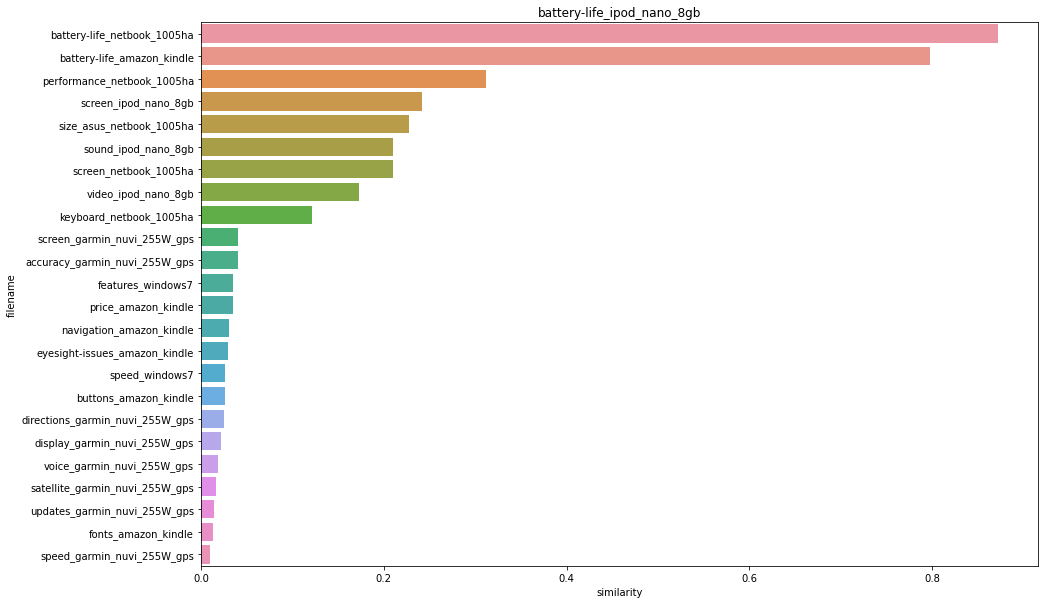

In [116]:
# 비교기준 문서와 다른 문서들간의 유사도 살펴보기
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
# array 내림차순으로 정렬한 후 인덱스 반환 [:,::-1] 모든행에 대해서 열을 내림차순으로!
sorted_idx = similarity.argsort()[:,::-1]
# 비교문서 당사자는 제외한 인덱스 추출
sorted_idx = sorted_idx[:, 1:]

# 유사도가 큰 순으로 hotel_idx(label=1인 즉, 호텔과관련된 내용의 문서이름들의 index들)에서 재 정렬 
# index로 넣으려면 1차원으로 reshape해주기!
hotel_sorted_idx = hotel_idx[sorted_idx.reshape(-1,)]
# 유사도 행렬값들을 유사도가 큰 순으로 재정렬(비교 문서 당사자는 제외)
hotel_sim_values = np.sort(similarity.reshape(-1,))[::-1]
hotel_sim_values = hotel_sim_values[1:]
# 이렇게 되면 비교문서와 가장 유사한 순으로 '해당문서의index-유사도값' 으로 동일한 위치가 매핑된 두 개의 array!
# 그래서 그대로 데이터프레임의 각 칼럼으로 넣어주기
print(hotel_sorted_idx)
print(hotel_sim_values)
print()
print("길이 비교", len(hotel_sorted_idx), len(hotel_sim_values))
print()
# 빈 데이터프레임 생성
hotel_sim_df = pd.DataFrame()
# hotel_sorted_idx 와 hotel_sim_values 매핑시킨 array임
hotel_sim_df['filename'] = document_df.iloc[hotel_sorted_idx]['filename']
hotel_sim_df['similarity'] = hotel_sim_values

plt.figure(figsize=(15,10))
sns.barplot(data=hotel_sim_df, x='similarity', y='filename')
plt.title(comparison_doc)